# Convolutional Neural Networks on CIFAR100
## Comparing AlexNet to VGG19 A Brief Analysis.
### By: Luis Cervantes & Sean Krinik

#### Sources: 
**CIFAR100 Dataset:** [CIFAR Datasets](https://www.cs.toronto.edu/~kriz/cifar.html) - Data source of train and test images <br>
**Keras.io:** [Keras.io](https://keras.io/) - All model implementation and documentation on models.

To begin, we will import the necessary modules for preprocessing and model fitting.

In [1]:
import numpy as np
import cv2, time, glob, os
import matplotlib.pyplot as plt
%matplotlib inline
import concurrent.futures

from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.models import load_model
import h5py

Using TensorFlow backend.


In [2]:
# Paths 
models_alexnet = './models_alexnet/'
models_vgg = './models_vgg/'

In [3]:
# Plot Loss Function:
def plot_loss_accuracy(history, modelname):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title(modelname + ' Cross Entropy Loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title(modelname + ' Accuracy')
    ax.grid(True)

Load the CIFAR100 data

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [5]:
print('Training Shape: ', x_train.shape) 
print('Test Shape: ', x_test.shape)

('Training Shape: ', (50000, 32, 32, 3))
('Test Shape: ', (10000, 32, 32, 3))


We get 50,000 images to train on, and 10,000 for evaluation. We will begin preprocessing the images for keras, and implement data augmentation.

The images are 32x32 pixels and 3 channels. This is the minimum size for VGG19, so we provide an implementation of vanilla VGG19 from scratch with no initial weights, and an ammended version with fewer max pooling layers (thus more parameters, but this may help accuracy since we retain more detail)

In [6]:
# Set up the encoded labels for keras:
number_of_classes = 100
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

A function to resize images using interpolation methods so we don't loose TOO much resolution in upsampling...

In [7]:
# we want 128x128 so we need a 400% increase
scale = 400
width = int((x_train.shape[1] * scale)/100)
height = width
dim = (width,height)

In [8]:
def resizeImg(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    return img

In [9]:
x_train_128 = []
x_test_128 = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for img in executor.map(resizeImg, x_train):
        x_train_128.append(img)
    for img in executor.map(resizeImg, x_test):
        x_test_128.append(img)
    x_train_128 = np.array(x_train_128)
    x_test_128 = np.array(x_test_128)

In [10]:
print(x_train_128.shape)
print(x_test_128.shape)

(50000, 128, 128, 3)
(10000, 128, 128, 3)


In [11]:
datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2,
                             rotation_range=15,
                             width_shift_range=0.05,
                             shear_range=0.25,
                             height_shift_range=0.05,
                             zoom_range=0.05)

In [12]:
# batches differ due to GPU memory: 
batch_size = 64
batch_size_128 = 32

# train:
train_gen = datagen.flow(x_train,
                            y_train,
                            subset= "training",
                            shuffle = True,
                            batch_size=batch_size)
train_gen_128 = datagen.flow(x_train_128,
                            y_train,
                            subset= "training",
                            shuffle = True,
                            batch_size=batch_size_128)
# validation:
val_gen = datagen.flow(x_train,
                            y_train,
                            subset = "validation",
                            shuffle = False,
                            batch_size=batch_size)
val_gen_128 = datagen.flow(x_train_128,
                            y_train,
                            subset = "validation",
                            shuffle = False,
                            batch_size=batch_size_128)

### AlexNet Architecture

To begin, we will build an AlexNet model to fit our application. We implement the semi-vanilla AlexNet architecture, close to the structure presented in the paper except for a few changes in filter size since our stock images are smaller. 

Note, the first convolutional layer uses a filter size of 5 instead of 11, with stride 3. This will give us an output size of 10 using the formula: 

$$\left[\frac{\text{Dimension} - \text{Filter}}{\text{Stride}}\right] +1$$

The original implementation of AlexNet used 227x227 images, filter size 11 and stride 4, making the output 55. This is around a 75% decrease in size from the original input dimension. We emulate that decrease with a filter size 5 and stride 3, yeilding 69% decrease in size. We will also follow a similar trend throughout the rest of the model where larger filters are applied. 

We also use the Nadam optimizer which is a Nesterov momentum implementation of the Adam optimizer. This optimizer allow for a variable change in momentum over each step to control the learning rate if it speeds up or slows down too drastically. 

The AlexNet paper is not as concise in explaining the ConvNet and its architecture since they seem to have written more about their seperable GPU implementation to split the computation across 2 GPU's and merge at certain points in the training process. This is not as common now since parallel computing functions exist in Keras (and so is normalization but we left the layers in there). The reference paper is found here: 

[ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

In [17]:
def create_alexnet(num_classes, imagedim):
    m_alexnet = Sequential()
    # Block 1
    m_alexnet.add(Conv2D(96, kernel_size=(5, 5),
                     strides = 3,
                     kernel_initializer='glorot_normal',
                     input_shape=[imagedim,imagedim,3]))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    m_alexnet.add(MaxPooling2D(pool_size=(2, 2), 
                               strides=2))

    # Block 2
    m_alexnet.add(ZeroPadding2D(padding=(1, 1)))
    m_alexnet.add(Conv2D(256, kernel_size=(3, 3),
                     padding = 'same'))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    m_alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3 
    m_alexnet.add(ZeroPadding2D(padding=(1, 1)))
    m_alexnet.add(Conv2D(384, kernel_size=(3, 3),
                     padding = 'same'))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    
    m_alexnet.add(ZeroPadding2D(padding=(1, 1)))
    m_alexnet.add(Conv2D(384, kernel_size=(3, 3),
                     padding = 'same'))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    
    m_alexnet.add(ZeroPadding2D(padding=(1, 1)))
    m_alexnet.add(Conv2D(384, kernel_size=(3, 3),
                     padding = 'same'))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    m_alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected 1
    m_alexnet.add(Flatten())
    m_alexnet.add(Dense(4096))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    m_alexnet.add(Dropout(rate=.5))

    # Fully Connected 2
    m_alexnet.add(Dense(4096))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('relu'))
    m_alexnet.add(Dropout(rate=.5))
    
    # Fully Connected Classification
    m_alexnet.add(Dense(num_classes))
    m_alexnet.add(BatchNormalization())
    m_alexnet.add(Activation('softmax'))
    
    m_alexnet.summary()
    
    m_alexnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', 'top_k_categorical_accuracy'])
    return m_alexnet

In [18]:
def train_alexnet(train_gen, val_gen, n_epochs, n_classes, imgdim, callbacks_bool):
    start = time.time()
    if callbacks_bool:
        callbacks_list = [
            #ModelCheckpoint(top_model_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1)
        ]
    else:
        callbacks_list = []
        
    # create model:    
    m_alexnet = create_alexnet(n_classes, imgdim)
    
    # Begin training:
    steps_train_data = train_gen.n//train_gen.batch_size
    steps_val_data = val_gen.n//val_gen.batch_size
    trained_alexnet = m_alexnet.fit_generator(train_gen,
                                       steps_per_epoch=steps_train_data,
                                       epochs=n_epochs,
                                       validation_data = val_gen,
                                       validation_steps = steps_val_data,
                                       callbacks=callbacks_list)
    print('Total Training Time: {}'.format(time.time() - start))
    return trained_alexnet, m_alexnet

In [19]:
exists = len(os.listdir(models_alexnet)) != 0

In [20]:
# check if a pretrained model exists:
if exists: 
    print('Loading previous model...')
    m_alexnet = load_model(glob.glob(models_alexnet + '*32.hdf5')[0])
    print('AlexNet Loaded.')
else:
    trained_alexnet, m_alexnet = train_alexnet(train_gen, val_gen, 30, number_of_classes, x_train.shape[1], True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 10, 96)        7296      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 96)          0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         221440    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 256)         1024      
__________

In [23]:
m_alexnet.save(models_alexnet + 'topmodel32.hdf5')

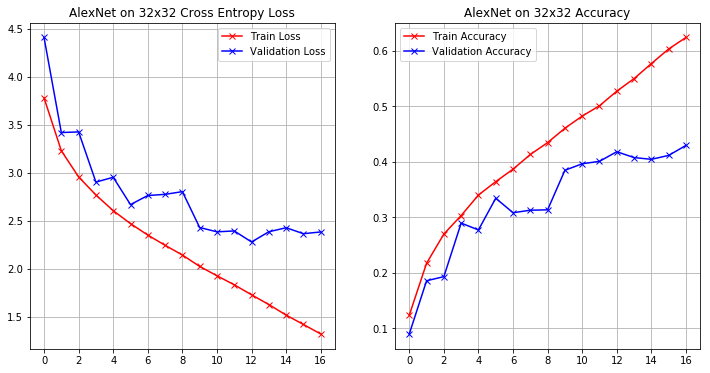

In [22]:
plot_loss_accuracy(trained_alexnet, 'AlexNet on 32x32')

In [24]:
score = m_alexnet.evaluate(x_test, y_test, verbose=1)
print('AlexNet Test Loss:', score[0])
print('AlexNet Accuracy:', score[1])
print('AlexNet Top-5 Accuracy', score[2])

10000/10000 [==============================] - 3s 291us/step
('AlexNet Test Loss:', 15.853575588989258)
('AlexNet Accuracy:', 0.0143)
('AlexNet Top-5 Accuracy', 0.8488)


#### AlexNet with upsampled CIFAR100 images

Now we run the same model on the 128x128 upsampled images to see if the added pixels will help with the learning process despite the images being upsampled. The images are larger but one caveat is that the upsampling uitlizes pixel interpolation to retain some resolution when creating the larger image. Perhaps some image integrity is comprimised in the process, hurting the overall edges or causing pixelation of the image. Despite the upsampling, we do expect better accuracy and loss.

In [25]:
# check if model exists
if exists: 
    print('Loading previous model...')
    m_alexnet128 = load_model(glob.glob(models_alexnet + '*128.hdf5')[0])
    print('AlexNet Loaded.')
else:
    trained_alexnet_128, m_alexnet128 = train_alexnet(train_gen_128, val_gen_128, 30, number_of_classes, width, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 42, 42, 96)        7296      
_________________________________________________________________
batch_normalization_9 (Batch (None, 42, 42, 96)        384       
_________________________________________________________________
activation_9 (Activation)    (None, 42, 42, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 96)        0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 256)       221440    
_________________________________________________________________
batch_normalization_10 (Batc (None, 23, 23, 256)       1024      
__________

In [28]:
m_alexnet128.save(models_alexnet + 'topmodel128.hdf5')

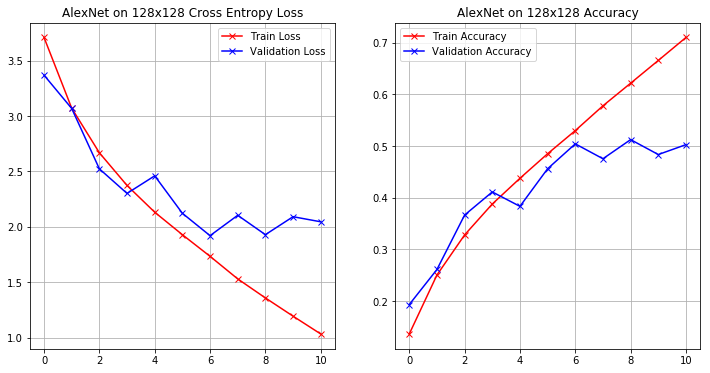

In [26]:
plot_loss_accuracy(trained_alexnet_128, 'AlexNet on 128x128')

In [29]:
score = m_alexnet128.evaluate(x_test_128, y_test, verbose=1)
print('AlexNet Test Loss:', score[0])
print('AlexNet Accuracy:', score[1])
print('AlexNet Top-5 Accuracy', score[2])

10000/10000 [==============================] - 8s 783us/step
('AlexNet Test Loss:', 15.809020584106445)
('AlexNet Accuracy:', 0.0182)
('AlexNet Top-5 Accuracy', 0.9073)


### VGG19 Architecture 

VGG19 uses 19 weight training layers instead of 16 with VGG16. The architecture of VGG19 is very similar to its predecessor. 

VGG models differ from the AlexNet architecture by using small convolutional filters (3x3) with short strides. By stacking these smaller filters over more convolutional layers, they were able to create an effective receptive area of a larger filter size, but creating less parameters in doing so. 

The paper on VGG19 is very informative and gives great insight into some current model architectures and their implementations. [Very Deep Convolutional Networks For Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [30]:
from keras.applications import VGG19
from keras import Model

In [38]:
def create_vgg(num_classes, imgdim):
    base_model = VGG19(input_shape=(imgdim, imgdim, 3), 
                       include_top=False, 
                       weights='imagenet')
    # replace the fully connected layer to fit our application:
    output = base_model.output
    output = GlobalAveragePooling2D()(output)
    output = Dense(num_classes, activation='softmax')(output)
    m_vgg = Model(base_model.input, output)
    
    m_vgg.summary()
    m_vgg.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=0.001, momentum=0.9, decay=5e-4, nesterov=True),
          metrics=['accuracy', 'top_k_categorical_accuracy'])
    return m_vgg

In [39]:
def train_vgg(train_gen, val_gen, n_epochs, n_classes, imgdim, callbacks_bool):
    start = time.time()
    if callbacks_bool:
        callbacks_list = [
            #ModelCheckpoint(top_model_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1)
        ]
    else:
        callbacks_list = []
        
    # create model:    
    m_vgg = create_vgg(n_classes, imgdim)
    
    # Begin training:
    steps_train_data = train_gen.n//train_gen.batch_size
    steps_val_data = val_gen.n//val_gen.batch_size
    trained_vgg = m_vgg.fit_generator(train_gen,
                                       steps_per_epoch=steps_train_data,
                                       epochs=n_epochs,
                                       validation_data = val_gen,
                                       validation_steps = steps_val_data,
                                       callbacks=callbacks_list)
    print('Total Training Time: {}'.format(time.time() - start))
    return trained_vgg, m_vgg

In [40]:
exists_vgg = len(os.listdir(models_vgg)) != 0

In [41]:
# check if model exists
if exists_vgg: 
    print('Loading previous model...')
    m_alexnet = load_model(glob.glob(models_alexnet + '*32.hdf5')[0])
    print('VGG19 Loaded.')
else:
    trained_vgg, m_vgg = train_vgg(train_gen, val_gen, 30, number_of_classes, x_train.shape[1], True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [44]:
m_vgg.save(models_vgg + 'topmodel32.hdf5')

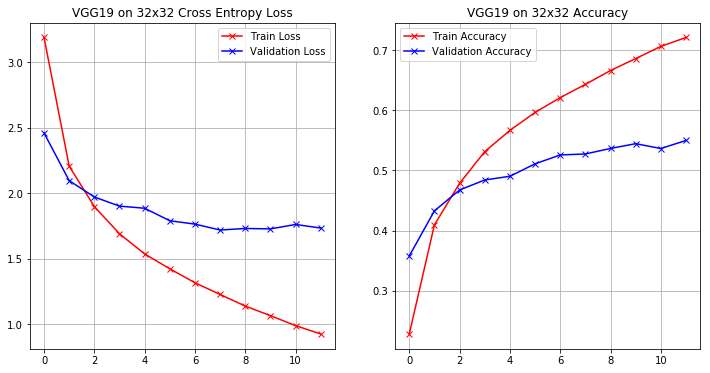

In [42]:
plot_loss_accuracy(trained_vgg, 'VGG19 on 32x32')

In [43]:
score = m_vgg.evaluate(x_test, y_test, verbose=1)
print('VGG19 Test Loss:', score[0])
print('VGG19 Accuracy:', score[1])
print('VGG19 Top-5 Accuracy:', score[2])

10000/10000 [==============================] - 4s 431us/step
('VGG19 Test Loss:', 9.589820986938477)
('VGG19 Accuracy:', 0.3969)
('VGG19 Top-5 Accuracy:', 0.9698)


#### VGG19 with upsampled CIFAR100 images

Now again, run the VGG19 architecture on the 128x128 upsampled images using the imagenet weights (transfer learning).

In [45]:
# check if model exists
if exists_vgg: 
    print('Loading previous model...')
    m_alexnet = load_model(glob.glob(models_alexnet + '*128.hdf5')[0])
    print('VGG19 Loaded.')
else:
    trained_vgg_128, m_vgg128 = train_vgg(train_gen_128, val_gen_128, 30, number_of_classes, width, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [48]:
m_vgg128.save(models_vgg + 'topmodel128.hdf5')

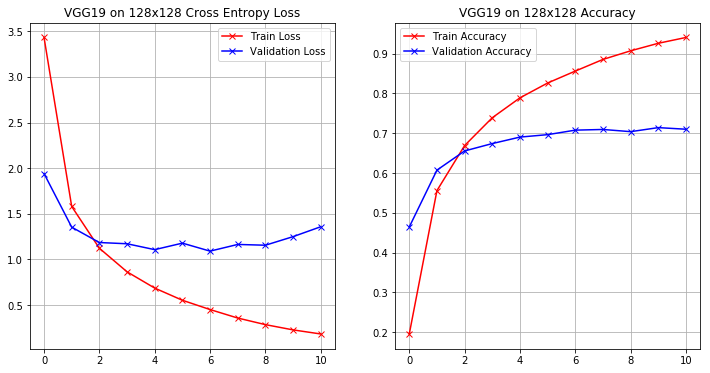

In [46]:
plot_loss_accuracy(trained_vgg_128, 'VGG19 on 128x128')

In [47]:
score = m_vgg128.evaluate(x_test_128, y_test, verbose=1)
print('VGG19 Test loss:', score[0])
print('VGG19 accuracy:', score[1])
print('VGG19 Top-5 Accuracy:', score[2])

10000/10000 [==============================] - 23s 2ms/step
('VGG19 Test loss:', 8.339326272583008)
('VGG19 accuracy:', 0.4739)
('VGG19 Top-5 Accuracy:', 0.9733)


### Conclusions:

To breifly summarize our findings, using transfer learning with VGG19 with imagenet initialization weights gave us the best result, obtaining a Top-5 test accuracy of 0.9698 on 32x32, and even higher at 0.9733 for the 128x128 case. Our AlexNet implementation was trained from scratch without using transfer learning. This could definitely be a contributor to the poor results, since all low and high level features had to be learned by the model on the first go, and our optimizer uses momentum to speed up the learning process, thus making it a bit harder for the model to pick up the low level features with precision. The AlexNet implementation achieved 0.8488 Top-5 test accuracy on 32x32 and 0.9073 on 128x128.

Additional note - the 32x32 images are very small, especially in the AlexNet case since the pooling layers cut down the output to 1 pixel by the end of the convolution blocks. Upsampling the images did improve both models drastically, showing that more image data really makes a difference, at least on CIFAR100 and colour images. 

Possible improvements include using different optimization techniques, more advanced tuning of hyperparameters and better implementation of transfer learning (using better weights for initialization).